# Tutorial
- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
- https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

<img src="resource/CVPR19_experiments.png" width="400px"/>

# Image

In [1]:
import numpy as np
from PIL import Image, ImageFile, ImageFilter
import matplotlib.pyplot as plt
plt.ion()

In [2]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

(500, 333)
JPEG


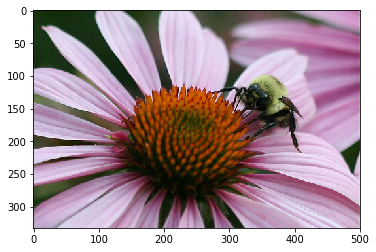

In [3]:
img = Image.open('hymenoptera_data/val/bees/181171681_c5a1a82ded.jpg')
print(img.size)
print(img.format)
plt.imshow(img)
# plt.imshow(np.array(img))    # works too

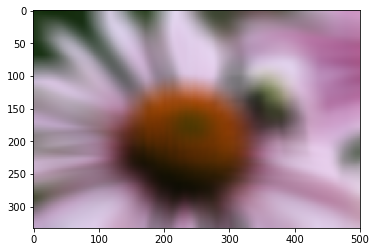

In [4]:
plt.imshow(img.filter(ImageFilter.BoxBlur(20)))

# Train

In [5]:
import copy
from datetime import datetime
import os
import warnings

from tensorboardX import SummaryWriter
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

In [6]:
warnings.filterwarnings("ignore")
print(torch.__version__)
print(torchvision.__version__)

1.0.0
0.2.2


In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'dev': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
splits = list(data_transforms.keys())
print(splits)

['train', 'dev', 'test']


In [8]:
# https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d
class ImageFolderWithPaths(datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]    # image file path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [9]:
image_datasets = {
    x: ImageFolderWithPaths(os.path.join('data', x), data_transforms[x]) for x in splits
}
print(image_datasets['train'].classes)
print(image_datasets['train'].class_to_idx)

['adult', 'main', 'text']
{'adult': 0, 'main': 1, 'text': 2}


In [10]:
# hyperparameters
batch_size = 64
num_workers = 4
num_epochs = 20
num_classes = len(image_datasets['train'].classes)

In [11]:
data_loaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=num_workers) for x in splits
}
dataset_sizes = {x: len(image_datasets[x]) for x in splits}
print(dataset_sizes)

{'train': 260898, 'dev': 14856, 'test': 14830}


In [12]:
print(torch.cuda.device_count())
print(torch.cuda.current_device())
torch.cuda.set_device(0)
# or
device = torch.device('cuda:0')   # cpu

8
0


In [13]:
def imshow(inp, title=None):
    fig, ax = plt.subplots(figsize=(8, 8))
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    if title is not None:
        plt.title(title)

In [14]:
inputs, labels, paths = next(iter(data_loaders['dev']))
print(inputs.shape)
print(labels)
print(paths[:5])

torch.Size([64, 3, 224, 224])
tensor([2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 0, 2, 2, 2, 0, 2, 2, 2, 0, 0,
        0, 1, 1, 0, 2, 1, 2, 0, 2, 0, 2, 0, 0, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 1,
        2, 0, 1, 1, 1, 1, 1, 0, 1, 2, 0, 1, 2, 0, 1, 2])
('data/dev/text/009534.jpeg', 'data/dev/text/007790.jpeg', 'data/dev/text/005956.jpeg', 'data/dev/text/010199.jpeg', 'data/dev/text/006585.jpeg')


torch.Size([3, 1810, 1810])


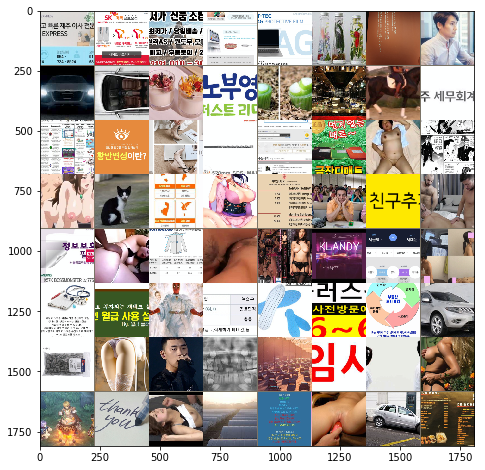

In [15]:
output = torchvision.utils.make_grid(inputs, nrow=8)
print(output.shape)
imshow(output)

In [16]:
def train(model, criterion, optimizer, num_epochs, every_n_step, logger):

    step = 1
    best_model = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0
    
    for epoch in range(num_epochs):

        start = datetime.now()
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        
        for phase in ['train', 'dev']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
        
            epoch_loss = 0.0
            epoch_correct = 0
            torch.cuda.empty_cache()
            
            for inputs, labels, _ in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        if step % every_n_step == 0:
                            logger.add_scalar('train/loss', loss.item(), step)
                            print('Step {:6d} loss: {:.4f}'.format(step, loss.item()))
                
                correct = torch.sum(preds == labels.data)
                epoch_loss += loss.item() * inputs.size(0)
                epoch_correct += correct
                if step % every_n_step == 0:
                    logger.add_scalar('train/accuracy', correct.double() / data_loaders[phase].batch_size, step)
                step += 1

            epoch_loss /= dataset_sizes[phase]
            epoch_accuracy = epoch_correct.double() / dataset_sizes[phase]
            print('{} loss: {:.4f} accuracy: {:.4f}'.format(phase, epoch_loss, epoch_accuracy))

            if phase == 'dev':
                if epoch_accuracy > best_accuracy:
                    best_accuracy = epoch_accuracy
                    best_model = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), 'dump/resnet50-ft-{}.bin'.format(epoch))
                logger.add_scalar('dev/loss', epoch_loss, step)
                logger.add_scalar('dev/accuracy', epoch_accuracy, step)
        
        end = datetime.now()
        print('Elapsed: {}'.format(end - start))
    
    print('Best accuracy: {:.4f}'.format(best_accuracy))
    model.load_state_dict(best_model)
    return model

In [17]:
model = models.resnet50(pretrained=True)
for param in model.parameters():    # freeze base
    param.requires_grad = False
!ls -l ~/.torch/models

합계 100100
-rw------- 1 irteam irteam 102502400  3월  9 01:54 resnet50-19c8e357.pth


In [18]:
model.fc = nn.Linear(model.fc.in_features, num_classes)
nn.init.xavier_uniform_(model.fc.weight)
_ = model.to(device)

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
logger = SummaryWriter('logs/exp-1')

In [ ]:
model = train(model, criterion, optimizer, num_epochs, every_n_step=10, logger=logger)

Epoch 1/20
Step     10 loss: 1.1152
Step     20 loss: 1.0552
Step     30 loss: 0.8834
Step     40 loss: 0.8203
Step     50 loss: 0.8238
Step     60 loss: 0.7193
Step     70 loss: 0.7218
Step     80 loss: 0.6930
Step     90 loss: 0.6042
Step    100 loss: 0.5712
Step    110 loss: 0.6327
Step    120 loss: 0.6141
Step    130 loss: 0.5903
Step    140 loss: 0.6818
Step    150 loss: 0.5534
Step    160 loss: 0.4995
Step    170 loss: 0.5734
Step    180 loss: 0.4374
Step    190 loss: 0.4797
Step    200 loss: 0.4302
Step    210 loss: 0.4054
Step    220 loss: 0.4325
Step    230 loss: 0.4667
Step    240 loss: 0.4495
Step    250 loss: 0.5030
Step    260 loss: 0.4059
Step    270 loss: 0.4043
Step    280 loss: 0.4211
Step    290 loss: 0.3223
Step    300 loss: 0.4117
Step    310 loss: 0.2988
Step    320 loss: 0.3921
Step    330 loss: 0.4265
Step    340 loss: 0.4636
Step    350 loss: 0.4647
Step    360 loss: 0.3710
Step    370 loss: 0.2701
Step    380 loss: 0.4317
Step    390 loss: 0.3259
Step    400 lo

# Test

In [21]:
# model.load_state_dict(torch.load('dump/resnet50-ft.bin'))
_ = model.eval()

In [22]:
correct = 0
preds_cpu = torch.LongTensor([])
truth_cpu = torch.LongTensor([])
for inputs, labels, paths in data_loaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    logits = torch.softmax(outputs, 1)
    probs, preds = torch.max(logits, 1)
    correct += torch.sum(preds == labels.data)
    preds_cpu = torch.cat((preds_cpu, preds.cpu()))
    truth_cpu = torch.cat((truth_cpu, labels.cpu()))
print(correct.double() / dataset_sizes['test'])

tensor(0.9472, device='cuda:0', dtype=torch.float64)


In [25]:
from sklearn.metrics import confusion_matrix

In [23]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           ylabel='True', xlabel='Pred', title=title)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

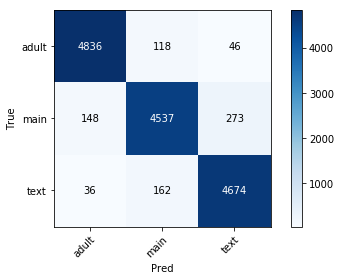

In [26]:
plot_confusion_matrix(truth_cpu, preds_cpu, image_datasets['test'].classes, cmap=plt.cm.Blues)